 <font size="5"> Introduction </font>

A/B tests are very commonly performed by data analysts and data scientists. It is important that you get some practice working with the difficulties of these

For this project, you will be working to understand the results of an A/B test run by an e-commerce website. Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

 <font size="5"> Part I - Probability </font>
 
To get started, let's import our libraries.

In [1]:
#Loading Libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/islamamer666/AB-Testing-Result-Analysis/main/Data/ab_data.csv',  error_bad_lines=False)
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [3]:
df.shape  

(294478, 5)

In [4]:
#The number of unique users in the dataset
unique_user = df['user_id'].nunique()
unique_user

290584

In [5]:
#The proportion of users converted
df.converted.mean()

0.11965919355605512

In [7]:
#Data Cleaning
#missing values
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [8]:
#The number of times the new_page and treatment don't line up
not_line_up_1 = df.query(" group=='treatment' and landing_page=='old_page'").count()
not_line_up_2 = df.query(" group=='control' and landing_page=='new_page'").count()
not_line_up_1 + not_line_up_2

user_id         3893
timestamp       3893
group           3893
landing_page    3893
converted       3893
dtype: int64

In [9]:
# only store the aligned data in df2
df2 = df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == True]
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [10]:
# Double Check all of the incorrect rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [11]:
df2['converted'].value_counts()

0    255832
1     34753
Name: converted, dtype: int64

In [12]:
df2['user_id'].nunique()

290584

In [13]:
#duplicated data
df2['user_id'].duplicated().sum()

1

In [14]:
# show the duplicated two rows 
df2[df2['user_id'].duplicated(keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [15]:
# drop duplicates 
df2.drop_duplicates(keep='first')
df2.duplicated().sum()

0

In [16]:
#What is the probability of an individual converting regardless of the page they receive?
round(df2.converted.mean(),4)


0.1196

In [17]:
#Given that an individual was in the control group, what is the probability they converted?
control_ver =float(df2.query("group=='control' and converted=='1'")['user_id'].nunique() ) 
control = float(df2.query("group=='control'")['user_id'].nunique())
round(control_ver / control,4)

0.1204

In [18]:
#Given that an individual was in the treatment group, what is the probability they converted?
treat_ver =float(df2.query("group=='treatment' and converted=='1'")['user_id'].nunique() ) 
treat = float(df2.query("group=='treatment'")['user_id'].nunique())
round(treat_ver / treat,4)

0.1188

In [19]:
#What is the probability that an individual received the new page?
new_page = float(df2.query("landing_page == 'new_page'")['user_id'].nunique())
total = float(df2.shape[0])
round(new_page / total,4)

0.5001

In [20]:
#What is the converted probability Given that an individual was in new landing page?
old_page = float(df2.query("landing_page == 'new_page' and converted == 1 ")['user_id'].nunique())
total = float(df2.query("landing_page == 'new_page'")['user_id'].nunique())
                  
round(old_page / total,4)

0.1188

e. Use the results in the previous two portions of this question to suggest if you think there is evidence that one page leads to more conversions? Write your response below.

Your answer goes here. No. About 12.04% control group is likely to be converted while 11.88% treatment group is likely to be converted. The result is quite similar. So there is no strong evidence to prove a certain page leads to more conversions.


<font size="5"> Part II - A/B Test</font>

Background Information to help you better understand the results :
If P value is really small, less likely to observe the statistic in the null , more likely from the alternative.
p-value is large you will end up staying with the null hypothesis as your choice.

Type 1 error threshold is alpha

If p < alpha , reject the null , choose H1
If p > alpha , fail to reject the null, choose H0
Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time? How long do you run to render a decision that neither page is better than another?

These questions are the difficult parts associated with A/B tests in general.

1. For now, consider you need to make the decision just based on all the data provided. If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be? You can state your hypothesis in terms of words or in terms of $p_{old}$ and $p_{new}$, which are the converted rates for the old and new pages.

Put your answer here.

H_O : p(new)-p(old)<=0 old has better conversion
H_1 : p(new)-p(old)>0 new has better conversion
2. Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the converted success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the converted rate in ab_data.csv regardless of the page.
Use a sample size for each page equal to the ones in ab_data.csv.


Perform the sampling distribution for the difference in converted between the two pages over 10,000 iterations of calculating an estimate from the null.


Use the cells below to provide the necessary parts of this simulation. If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem. You can use Quiz 5 in the classroom to make sure you are on the right track.


a. What is the convert rate for $p_{new}$ under the null?

In [21]:
# in question 2, it says assuming under null hypothesis, p(new) = p(old) ,
# and they are equal to the converted ratein ab_data.csv regardless of the page. 
 
p_new = round(float(df2.query('converted=="1"').user_id.nunique()) / float(df2.shape[0]), 4)
p_new
# here, pay attention to the variable name , can not be p(new)

0.1196

In [22]:
# What is the convert rate for $p_{old}$ under the null?
p_old = round(float(df2.query('converted=="1"').user_id.nunique()) / float(df2.shape[0]) , 4 )
p_old

0.1196

In [23]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [24]:
# unique number of accessing new page 
N_new = df2.query('landing_page == "new_page"')['user_id'].nunique()
N_new

145310

In [25]:
# unique number of accessing old page 
N_old = df2.query('landing_page == "old_page"')['user_id'].nunique()
N_old

145274

In [26]:
#Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null. Store these $n_{new}$ 1's and 0's in new_page_converted
new_page_converted = np.random.choice([0,1] , N_new , p=(p_new,1-p_new))
new_page_converted

array([1, 0, 1, ..., 1, 1, 1])

In [27]:
#Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null. Store these $n_{old}$ 1's and 0's in old_page_converted
old_page_converted = np.random.choice([0,1] , N_old , p=(p_old,1-p_old))
old_page_converted

array([0, 0, 1, ..., 1, 1, 1])

In [28]:
new_page_converted.mean() , old_page_converted.mean()

(0.8800908402725208, 0.8791249638613929)

In [29]:
#Find p_new - p_old for your simulated values from part (e) and (f).
obs_diff = new_page_converted.mean() - old_page_converted.mean()
obs_diff

0.0009658764111278861

In [30]:
#Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts a. through g. above. Store all 10,000 values in p_diffs.
#Import timeit package
#import timeit
#start = timeit.default_timer()

# Create sampling distribution for difference in completion rates
# with boostrapping
#p_diffs = []
#size = df.shape[0]
#for _ in range(10000):
#    samp = df2.sample(size, replace = True)
#    new_page_converted = np.random.choice([0,1],N_new, p=(p_new,1-p_new))
#    old_page_converted = np.random.choice([0,1],N_old, p=(p_old,1-p_old))
#    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())
    
#Compute python running time.
#stop = timeit.default_timer()
#print(stop - start)

# the above code does not work well and takes too much time to run
p_diffs=[]
new_convert=np.random.binomial(N_new, p_new, 10000)/N_new
old_convert=np.random.binomial(N_old, p_old, 10000)/N_old
p_diffs=new_convert-old_convert

(array([   4.,   43.,  317., 1205., 2829., 3027., 1864.,  608.,   88.,
          15.]),
 array([-0.00509516, -0.00411852, -0.00314189, -0.00216526, -0.00118863,
        -0.000212  ,  0.00076463,  0.00174127,  0.0027179 ,  0.00369453,
         0.00467116]),
 <a list of 10 Patch objects>)

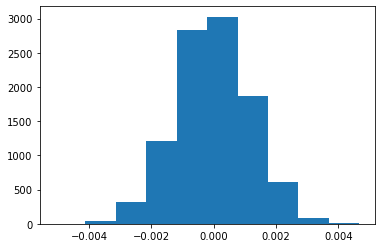

In [31]:
#Plot a histogram of the p_diffs. Does this plot look like what you expected? Use the matching problem in the classroom to assure you fully understand what was computed here.
p_diffs = np.array(p_diffs)
plt.hist(p_diffs)

In [32]:
#compute actual conversion rate
# number of landing new page and converted  / number of landing new page
converted_new = df2.query('converted == 1 and landing_page== "new_page"')['user_id'].nunique()
actual_new = float(converted_new) / float(N_new)

# number of landing old page and converted  / number of landing old page
converted_old = df2.query('converted == 1 and landing_page== "old_page"')['user_id'].nunique()
actual_old = float(converted_old) / float(N_old)

#observed difference in converted rate
obs_diff = actual_diff = actual_new - actual_old
obs_diff

-0.0015782389853555567

In [33]:
#What proportion of the p_diffs are greater than the actual difference observed in ab_data.csv?
# create distribution under the null hypothesis
null_vals = np.random.normal(0, p_diffs.std(), p_diffs.size)

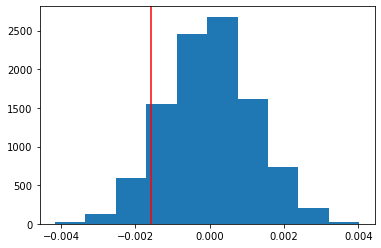

In [34]:
#Plot Null distribution
plt.hist(null_vals)
#Plot vertical line for observed statistic
plt.axvline(x=obs_diff,color ='red')

In [35]:
(null_vals > obs_diff).mean()

0.9114

k. In words, explain what you just computed in part j.. What is this value called in scientific studies? What does this value mean in terms of whether or not there is a difference between the new and old pages?

Put your answer here.

The value 0.9061 we call it P-value, which suggests if there is a significant difference between 2 groups for a hypothesis. In this case, the new page doesn't have better conversion rates than the old page because the value 0.9 is much higher than the alpha, 0.05(Type I error rate ). We fail to reject the null. Therefore, the data show, with a type I error rate of 0.05, that the old page has higher probablity of convert rate than new page.

l. We could also use a built-in to achieve similar results. Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let n_old and n_new refer the the number of rows associated with the old page and new pages, respectively.

In [36]:
import statsmodels.api as sm

convert_old = df2.query('converted == 1 and landing_page== "old_page"').user_id.nunique()
convert_new = converted_old = df2.query('converted == 1 and landing_page== "new_page"').user_id.nunique()
n_old = df2.query('landing_page == "old_page"')['user_id'].nunique()
n_new = df2.query('landing_page == "new_page"')['user_id'].nunique()

convert_old,convert_new , n_old , n_new

(17489, 17264, 145274, 145310)

In [37]:
# compute the sm.stats.proportions_ztest using the alternative
z_score, p_value = sm.stats.proportions_ztest(np.array([convert_new,convert_old]),np.array([n_new,n_old]), alternative = 'larger')
z_score, p_value

#  it's a one tail test so a z-score past 1.96 will be significant.

(-1.3109241984234394, 0.9050583127590245)

In [38]:
#from scipy.stats import norm
#norm.cdf(z_score) , norm.ppf(1-(0.05/2))
# norm.cdf(z_score):    how significant our z-score is
# norm.ppf(1-(0.05/2))  what our critical value at 95% confidence is

What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages? Do they agree with the findings in parts j. and k.?

Put your answer here.

Since the z-score of 1.3109241984234394 does not exceed the critical value of 1.959963984540054, we fail to reject the null hypothesis. Therefore, the converted rate for new page and old page have no difference. This result is the same as parts J. and K. result.

The z-score is greater than the value of -0.1645 (one-tail test) and hence it suggests that we can't reject the null.

And the p-value determines the significance of our resuls. The values are different from parts j and k but it still suggests that there is no statistically significant difference betweem the new and the old page.

Part III - A regression approach
1. In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.


a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

Put your answer here. Logistic Regression because the response variable is categorical

b. The goal is to use statsmodels to fit the regression model you specified in part a. to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create a colun for the intercept, and create a dummy variable column for which page each user received. Add an intercept column, as well as an ab_page column, which is 1 when an individual receives the treatment and 0 if control.

In [39]:
# create a colun for the intercept
df2['intercept'] = 1
df2.head()

<ipython-input-39-cc971ef543ce>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['intercept'] = 1


,user_id,timestamp,group,landing_page,converted,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1


In [40]:
# create a dummy variable column for which page each user received
df2['ab_page'] = pd.get_dummies(df['group'])['treatment']
df2.head()

<ipython-input-40-f2794af53026>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['ab_page'] = pd.get_dummies(df['group'])['treatment']


,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


Use statsmodels to import your regression model. Instantiate the model, and fit the model using the two columns you created in part b. to predict whether or not an individual converts.

In [41]:
log_mod = sm.Logit(df2['converted'], df2[['intercept','ab_page']])
results = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


 Provide the summary of your model below, and use it as necessary to answer the following questions.

In [42]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290585
Model:                          Logit   Df Residuals:                   290583
Method:                           MLE   Df Model:                            1
Date:                Wed, 17 Mar 2021   Pseudo R-squ.:               8.085e-06
Time:                        22:05:22   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1897
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.312      0.190      -0.037       0.007
==============================================================================
"""

. What is the p-value associated with ab_page? Why does it differ from the value you found in the Part II?

Hint: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the Part II?

Put your answer here.

p-value associated with ab_page is 0.19, which is different from the value found in PartII (0.9).

Reason :

In Part II, A/B Test method , the hypothesis test is under :
null hypothesis: 𝑝_𝑛𝑒𝑤 <= 𝑝_𝑜𝑙𝑑 , Alternative hypothesis p_new > p_old
In Part III under logistic model, the hypothesis test is under :
null hypothesis: 𝑝_𝑛𝑒𝑤 = 𝑝_𝑜𝑙𝑑 , Alternative hypothesis p_new ≠ p_old
Part III under regression method 'not equal' which is a two sided test, while Part II under A/B test method is a one tailed test

it has something to do with the bimodal distribution. We actually have an effect that the old page has slightly better conversion, the p-value is essentially 2(1 - (value)), to shade the tails. It essentially suggests there is not statistical evidence of a difference in the two conversion rates, but the connection between the p-value here and the p-value above is a bit disconnected because of the directional component of the previous alternative hypothesis.

f. Now, you are considering other things that might influence whether or not an individual converts. Discuss why it is a good idea to consider other factors to add into your regression model. Are there any disadvantages to adding additional terms into your regression model?

Put your answer here.

we can consider "timestamp" becuase the conversion rate is likely to have some kind of connection with different dates when it comes with holiday promotions, or different time like evenings when people get off work.

Disadvantage: the more terms , the model will be more complex. The results will be harder to interprete

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the countries.csv dataset and merge together your datasets on the approporiate rows. Here are the docs for joining tables.

Does it appear that country had an impact on conversion? Don't forget to create dummy variables for these country columns - Hint: You will need two columns for the three dummy varaibles. Provide the statistical output as well as a written response to answer this question.

In [44]:
df_country = pd.read_csv('https://raw.githubusercontent.com/islamamer666/AB-Testing-Result-Analysis/main/Data/countries.csv')
df_country.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [45]:
# join two dataframes on common column 'user_id'
df3 = df2.join(df_country.set_index('user_id'),on='user_id')
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [46]:
df3['country'].value_counts()

US    203620
UK     72466
CA     14499
Name: country, dtype: int64

In [47]:
# create dummy variables for country
df3[['US','UK','CA']] = pd.get_dummies(df3['country'])
df3 = df3.drop(df3['CA'])
df3['intercept'] = 1
log_mod = sm.Logit(df3['converted'], df3[['intercept','US','UK','ab_page']]) 
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366114
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290583
Model:                          Logit   Df Residuals:                   290579
Method:                           MLE   Df Model:                            3
Date:                Wed, 17 Mar 2021   Pseudo R-squ.:               2.326e-05
Time:                        22:09:47   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1756
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.760      0.000      -2.007      -1.972
US            -0.0408      0.027     -1.516      0.129      -0.093       0.012
UK             0.0099      0.013      0.743      0.458      -0.016       0.036
ab_page       -0.0150      0.011     -1.309      0.191      -0.037       0.007
==============================================================================
"""

In [48]:
1/np.exp(-0.0150),np.exp(0.0506),np.exp(0.0408)

(1.015113064615719, 1.0519020483004984, 1.0416437559600236)

 Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion. Create the necessary additional columns, and fit the new model.

Provide the summary results, and your conclusions based on the results

In [49]:
# create dummy variables for country
df3['intercept'] = 1
# interaction between page and country 
df3['US_new'] = df3['US'] * df3['ab_page']
df3['UK_new'] = df3['UK'] * df3['ab_page']
log_mod = sm.Logit(df3['converted'], df3[['intercept','ab_page','US','UK','US_new' ,'UK_new' ]])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366110
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290583
Model:                          Logit   Df Residuals:                   290577
Method:                           MLE   Df Model:                            5
Date:                Wed, 17 Mar 2021   Pseudo R-squ.:               3.485e-05
Time:                        22:10:50   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1915
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.341      0.000      -2.005      -1.968
ab_page       -0.0206      0.014     -1.508      0.132      -0.047       0.006
US            -0.0176      0.038     -0.466      0.641      -0.091       0.056
UK            -0.0058      0.019     -0.307      0.759      -0.043       0.031
US_new        -0.0469      0.054     -0.871      0.384      -0.152       0.059
UK_new         0.0314      0.027      1.182      0.237      -0.021       0.084
==============================================================================
"""